In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pickle


plt.style.use("../science.mplstyle")

from helpers.physics_functions import bkg_fit_cubic, bkg_fit_septic, bkg_fit_quintic, get_bins, select_top_events_fold, curve_fit_m_inv, calc_significance, get_errors_bkg_fit_ratio
from helpers.evaluation import get_median_percentiles

This notebook should be run twice:

1. `train_samesign = False` gives the "standard" results. i.e. we run the studies on the OS samples
2. `train_samesign = True` comes from running the Ml study on the SS samples.

**CAUTION**: for the histograms, we are truly showing the significance as $\frac{S}{\sqrt{B+{\sigma_B}^2}}$, i.e. we are accounting for the background error. For the ROC curves, this error is *NOT* being taken into account (it's not clear to me that we want this background error when we are just citing the background yield for the FPR)

In [2]:
import yaml
with open("workflow.yaml", "r") as file:
    workflow = yaml.safe_load(file) 

# pickles contain all the results from the BDT training
pickle_save_dir_prefix = "/global/cfs/cdirs/m3246/rmastand/dimuonAD/pickles/mix_2"
train_samesign = False

working_dir = f"/global/cfs/cdirs/m3246/rmastand/dimuonAD/projects/logit_08_22/"

# basically hard-coded for the PRL 
num_pseudoexperiments = 50
n_folds = 5
particle_type = "upsilon_iso"
particle_id = "upsilon"

In [3]:
SB_left = float(workflow[particle_id]["SB_left"])
SR_left = float(workflow[particle_id]["SR_left"])
SR_right = float(workflow[particle_id]["SR_right"])
SB_right = float(workflow[particle_id]["SB_right"])

# somewhat complicated code to set naming conventions
if train_samesign:
    train_data_id = "_samesign"
else:
    train_data_id = ""

# train on opp sign means alt test set is samesign
if train_data_id == "": 
    alt_test_data_id = "_samesign"
    train_data_id_title = "_oppsign"
elif train_data_id == "_samesign": 
    alt_test_data_id = ""
    train_data_id_title = "_samesign"

## Load in the BDT results

In [4]:
# if train_samesign = False, this loads in the OS test data
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_test_data_splits", "rb") as ifile:
    all_test_data_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_scores_splits", "rb") as ifile:
    all_alt_scores_splits = pickle.load(ifile)
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_scores_splits", "rb") as ifile:
    all_scores_splits = pickle.load(ifile)
# if train_samesign = False, this loads in the SS test data, OS high-stats data, and OS flow samples
# if train_samesign = True, this loads in the OS test data, SS high-stats data, and SS flow samples
with open(f"{pickle_save_dir_prefix}_{particle_type}{train_data_id_title}/all_alt_data_splits", "rb") as ifile:
    all_alt_data_splits = pickle.load(ifile)
with open(f"{working_dir}/processed_data/mass_scaler_{particle_type}", "rb") as ifile:
    scaler = pickle.load(ifile)

## Plot histograms for a small number of FPR thresholds

In [5]:
fpr_thresholds = [1, 0.25, 0.1, 0.05, 0.01]

# determine score cutoffs for each pseudoexperiments
score_cutoffs = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        
        for threshold in fpr_thresholds:
            
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs[pseudo_e][i_fold][threshold] = loc_score_cutoff


In [9]:
def plot_histograms_with_fits(fpr_thresholds, data_dict_by_fold, scores_dict_by_fold, score_cutoffs_by_fold, mass_scalar, fit_type, title, SB_left, SR_left, SR_right, SB_right, n_folds= 5, take_score_avg=True):
    
    if fit_type == "cubic": fit_function = bkg_fit_cubic
    elif fit_type == "quintic": fit_function = bkg_fit_quintic
    elif fit_type == "septic": fit_function = bkg_fit_septic

    # define bins and bin edges for the SB and SR
    # change the bin width with `num_bins_SR`
    plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 6)

    plt.figure(figsize = (12, 9))
    for t, threshold in enumerate(fpr_thresholds):
        
        filtered_masses = []

        # for each fold, select the events that meet the fpr threshold
        for i_fold in range(n_folds):
            loc_true_masses = mass_scalar.inverse_transform(np.array(data_dict_by_fold[i_fold][:,-1]).reshape(-1,1))
            if take_score_avg:
                loc_scores = np.mean(scores_dict_by_fold[i_fold], axis = 1)
            else:
                loc_scores = scores_dict_by_fold[i_fold]
            loc_filtered_masses, loc_SBL_eff, loc_SBH_eff, loc_SR_eff = select_top_events_fold(loc_true_masses, loc_scores, score_cutoffs_by_fold[i_fold][threshold],plot_bins_left, plot_bins_right, plot_bins_SR)
            filtered_masses.append(loc_filtered_masses)
        # consolidate the fold information
        filtered_masses = np.concatenate(filtered_masses)

        # get the fit function to SB background
        popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
        #print("chi2/dof:", chi2/n_dof)
        
        # plot the fit function
        plt.plot(plot_centers_all, fit_function(plot_centers_all, *popt), lw = 2, linestyle = "dashed", color = f"C{t}")    

        # calculate significance of bump
        num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        y_err = get_errors_bkg_fit_ratio(popt, pcov, plot_centers_SR, fit_type)
        B_error = np.sqrt(np.sum(y_err**2))
        S_over_B = num_S_expected_in_SR/num_B_expected_in_SR
        significance = num_S_expected_in_SR/np.sqrt(num_B_expected_in_SR+B_error**2)

        label_string = str(round(100*threshold, 2))+"% FPR: $S/B$: "+str(round(S_over_B,2))+", $S/\sqrt{B}$: "+str(round(significance,2))

        plt.hist(filtered_masses, bins = plot_bins_all, lw = 3, histtype = "step", color = f"C{t}",label = label_string)
        plt.scatter(plot_centers_SB, y_vals, color = f"C{t}")


    plt.legend(loc = (1, 0), fontsize = 24)


    plt.axvline(SR_left, color= "k", lw = 3, zorder = -10)
    plt.axvline(SR_right, color= "k", lw = 3, zorder = -10)

    plt.xlabel("$M_{\mu\mu}$ [GeV]", fontsize = 24)
    plt.ylabel("Counts", fontsize = 24)

    plt.title(title, fontsize = 24)
    


In [10]:
pseudo_e_to_plot = 0
fit_type = "quintic"

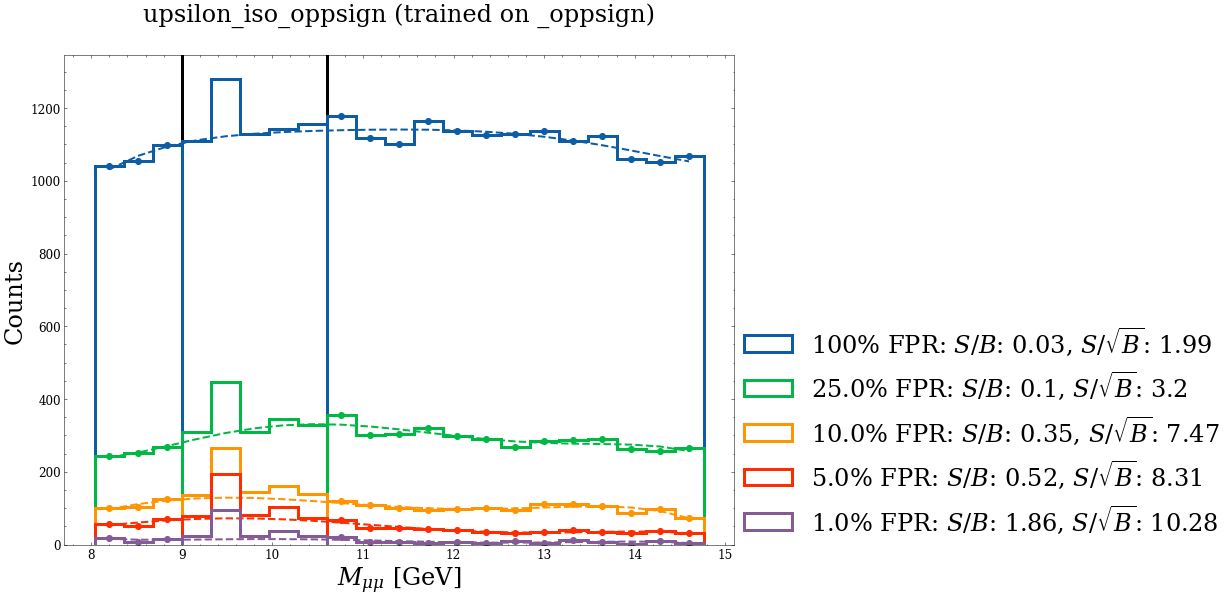

In [11]:

"""
PLOT HISTOGRAM ON SMALL TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_test_data_splits[pseudo_e_to_plot], all_scores_splits[pseudo_e_to_plot], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"{particle_type}{train_data_id_title} (trained on {train_data_id_title})\n", 
                          SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


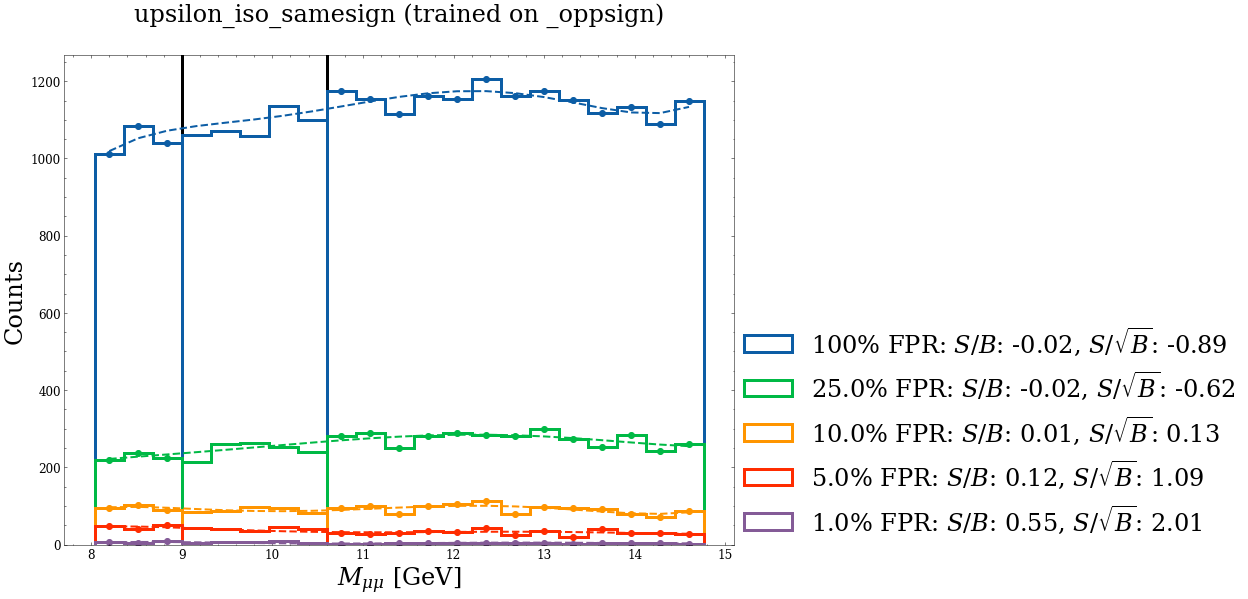

In [12]:


"""
PLOT HISTOGRAM ON ALTERNATIVE TEST SET
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["alt"], all_alt_scores_splits[pseudo_e_to_plot]["alt"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type, f"{particle_type}{alt_test_data_id} (trained on {train_data_id_title})\n",SB_left, SR_left, SR_right, SB_right, take_score_avg=False)





In [13]:
"""
PLOT HISTOGRAM ON ROC TEST DATA
"""
# this plot won't be shown in the main body -- this is just the high-stats set that is used to create the ROC curve

#plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_data"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_data"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats data _oppsign (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)



'\nPLOT HISTOGRAM ON ROC TEST DATA\n'

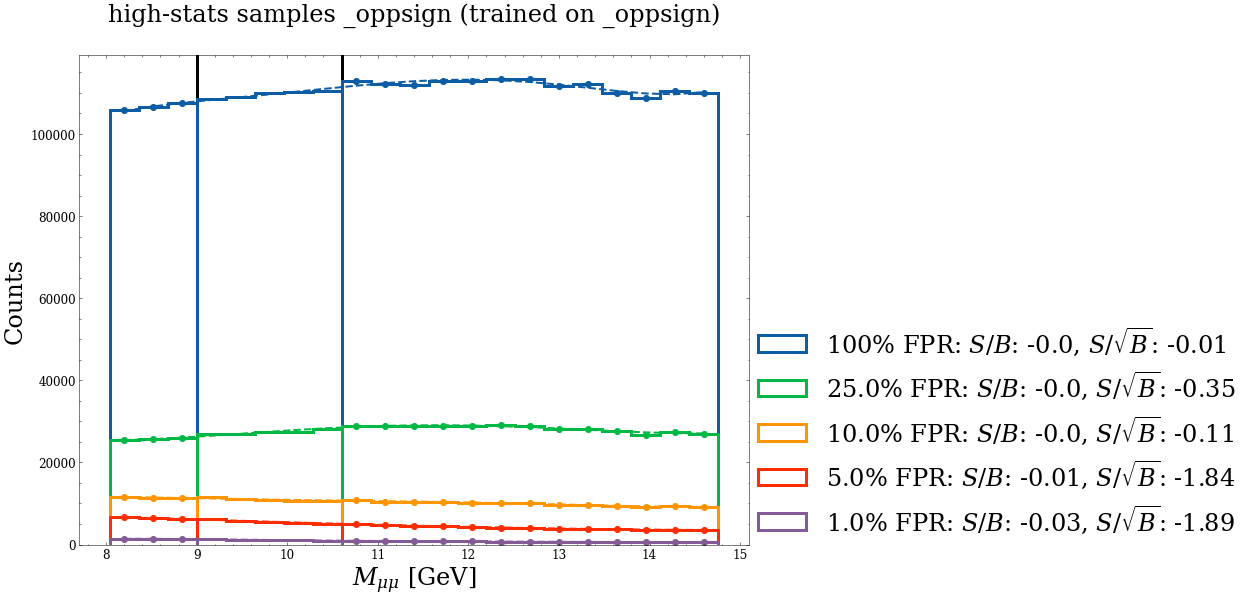

In [14]:
"""
PLOT HISTOGRAM ON FLOW SAMPLES
"""
plot_histograms_with_fits(fpr_thresholds, all_alt_data_splits[pseudo_e_to_plot]["ROC_samples"], all_alt_scores_splits[pseudo_e_to_plot]["ROC_samples"], score_cutoffs[pseudo_e_to_plot], scaler, fit_type,f"high-stats samples {train_data_id_title} (trained on {train_data_id_title})\n", SB_left, SR_left, SR_right, SB_right, take_score_avg=False)


# Plot ROC

In [15]:
fit_type = "quintic"
fit_function = bkg_fit_quintic

In [16]:
"""
CALCULATE THE ROC CURVES
"""

# determine fpr thresholds as before
# yes this is repeated code
fpr_thresholds_finegrained = np.logspace(0, -3, 20)
#fpr_thresholds = np.linspace(1, 0 , 50)

plot_bins_all, plot_bins_SR, plot_bins_left, plot_bins_right, plot_centers_all, plot_centers_SR, plot_centers_SB = get_bins(SR_left, SR_right, SB_left, SB_right, num_bins_SR = 6)


# first determine score cutoffs
score_cutoffs_finegrained = {pseudo_e:{i:{threshold:0 for threshold in fpr_thresholds_finegrained} for i in range(n_folds)} for pseudo_e in range(num_pseudoexperiments)}

for pseudo_e in range(num_pseudoexperiments):
    for i_fold in range(n_folds):
        loc_scores_sorted = np.sort(1.0-all_alt_scores_splits[pseudo_e]["FPR_validation"][i_fold])
        for threshold in fpr_thresholds_finegrained:
            loc_score_cutoff = 1-loc_scores_sorted[min(int(threshold*len(loc_scores_sorted)),len(loc_scores_sorted)-1)]
            score_cutoffs_finegrained[pseudo_e][i_fold][threshold] = loc_score_cutoff

        
def get_classifier_metrics_high_stats(dataset_id, score_cutoffs):
            
    S_yield, B_yield = np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments)), np.empty((fpr_thresholds_finegrained.shape[0], num_pseudoexperiments))

    for pseudo_e in range(num_pseudoexperiments):

        print(f"On pseudo experiment {pseudo_e+1}...")
        for t, threshold in enumerate(fpr_thresholds_finegrained):

            filtered_masses_bs = []

            for i_fold in range(n_folds):
                loc_true_masses_bs = scaler.inverse_transform(np.array(all_alt_data_splits[pseudo_e][dataset_id][i_fold][:,-1]).reshape(-1,1))
                loc_scores_bs = all_alt_scores_splits[pseudo_e][dataset_id][i_fold]
                # filter top event based on score cutoff
                loc_filtered_masses_bs, _, _, _ = select_top_events_fold(loc_true_masses_bs, loc_scores_bs, score_cutoffs[pseudo_e][i_fold][threshold], plot_bins_left, plot_bins_right, plot_bins_SR)
                filtered_masses_bs.append(loc_filtered_masses_bs)

            filtered_masses_bs = np.concatenate(filtered_masses_bs)
            # get the fit function to SB background
            popt, pcov, chi2, y_vals, n_dof = curve_fit_m_inv(filtered_masses_bs, fit_type, SR_left, SR_right, plot_bins_left, plot_bins_right, plot_centers_SB)
            num_S_expected_in_SR, num_B_expected_in_SR = calc_significance(filtered_masses_bs, fit_function, plot_bins_SR, plot_centers_SR, SR_left, SR_right, popt)
        
            S_yield[t, pseudo_e] = num_S_expected_in_SR
            B_yield[t, pseudo_e] = num_B_expected_in_SR
        
    # calculate summary stats
    TPR = S_yield/S_yield[0,:]
    FPR = B_yield/B_yield[0,:]
    

    ROC = 1.0/FPR

    SIC = TPR/np.sqrt(FPR)
    
    return TPR, FPR, ROC, SIC



In [17]:


TPR, FPR, ROC, SIC = get_classifier_metrics_high_stats("ROC_data", score_cutoffs_finegrained)



On pseudo experiment 1...


KeyError: 'ROC_data'

In [ ]:
     
TPR_median, TPR_lower, TPR_upper = get_median_percentiles(TPR)
FPR_median, FPR_lower, FPR_upper = get_median_percentiles(FPR)
ROC_median, ROC_lower, ROC_upper = get_median_percentiles(ROC)
SIC_median, SIC_lower, SIC_upper = get_median_percentiles(SIC)

plt.figure(figsize = (5, 5))
plt.plot(FPR_median, TPR_median)
plt.fill_between(FPR_median, TPR_lower, TPR_upper, alpha = 0.3 )
plt.plot(FPR_median, FPR_median, linestyle = "dashed", color = "grey")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.title(f"high-stats data _oppsign (trained on {train_data_id_title})")
plt.show()



In [ ]:
fig, ax = plt.subplots(1, 2, figsize = (10, 4))


ax[0].plot(TPR_median, ROC_median)
ax[0].fill_between(TPR_median, ROC_lower, ROC_upper, alpha = 0.3 )
ax[0].plot(TPR_median, 1.0/TPR_median, linestyle = "dashed", color = "grey")
ax[0].set_xlabel("TPR")
ax[0].set_ylabel("1/FPR")
ax[0].set_yscale("log")

ax[1].plot(TPR_median, SIC_median)
ax[1].fill_between(TPR_median, SIC_lower, SIC_upper, alpha = 0.3 )
ax[1].plot(TPR_median, TPR_median/np.sqrt(TPR_median), linestyle = "dashed", color = "grey")
ax[1].set_xlabel("TPR")
ax[1].set_ylabel("SIC")

plt.show()
